In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import time

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
from scipy.stats import uniform, randint

# First Dataset

In [2]:
filipino_news_df = pd.read_csv('./Philippine_Fake_News_(Filipino Language).csv')

In [3]:
filipino_news_df.head()

,label,article
0,0,"Ayon sa TheWrap.com, naghain ng kaso si Krupa,..."
1,0,Kilala rin ang singer sa pagkumpas ng kanyang ...
2,0,"BLANTYRE, Malawi (AP) -- Bumiyahe patungong Ma..."
3,0,"Kasama sa programa ang pananalangin, bulaklak ..."
4,0,Linisin ang Friendship Department dahil dadala...


#### Vocabulary Size

In [4]:
vectorizer = CountVectorizer()

# Fit and transform the 'text' column to get the document-term matrix
temp = vectorizer.fit_transform(filipino_news_df['article'])

# Get the vocabulary from the vectorizer
filipino_vocabulary = vectorizer.get_feature_names_out()

# Get the size of the vocabulary
filipino_vocabulary_size = len(filipino_vocabulary)
print("Vocabulary size:",filipino_vocabulary_size)

Vocabulary size: 39063


#### Splitting data into train and test data

In [5]:
X_train, X_test, y_train, y_test = train_test_split(filipino_news_df['article'], filipino_news_df['label'], test_size=0.2, random_state=42)

#### Count Vectorizer

#### Setting the range of parameters for tuning

In [6]:
param_dist_count = {
    'vectorizer__ngram_range': [(1, 1), (1, 2), (2, 2)],
    'classifier__n_estimators': range(10,201,10),
    'classifier__max_depth': np.arange(3,11,1),
    'classifier__learning_rate': np.arange(0.1,2.0,0.05),
}

##### Using the Whole Vocabulary

In [7]:
pipeline = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('classifier', XGBClassifier())
])
random_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_dist_count,
    n_iter=15,
    scoring='f1',
    n_jobs=-1,
    cv=3,
    verbose=1,
    random_state=42
)

# Record the training time
start_time = time.time()
random_search.fit(X_train, y_train)
end_time = time.time()
training_time_count_whole = end_time - start_time

# Print the best parameters and best score
print("Best Parameters: ", random_search.best_params_)
print("Best F1 Score: {:.4f}".format(random_search.best_score_))

# # Evaluate the model on the test set
test_f1_score = random_search.score(X_test, y_test)
print("Test F1: {:.4f}".format(test_f1_score))
print("Training time for whole data set: {:.4f}".format(training_time_count_whole))


Fitting 3 folds for each of 15 candidates, totalling 45 fits
Best Parameters:  {'vectorizer__ngram_range': (1, 1), 'classifier__n_estimators': 120, 'classifier__max_depth': 3, 'classifier__learning_rate': 0.3500000000000001}
Best F1 Score: 0.9450
Test F1: 0.9496
Training time for whole data set: 260.5606


In [8]:
training_times_count = []

best_count_f1 = 0.0
best_count_max_features = None
best_count_parameters = {}

# Initialize the RandomizedSearchCV
for max_features in range(500,10001,1500):
    # Create a pipeline with CountVectorizer and XGBoost
    pipeline = Pipeline([
        ('vectorizer', CountVectorizer(max_features=max_features)),
        ('classifier', XGBClassifier())
    ])
    random_search = RandomizedSearchCV(
        pipeline,
        param_distributions=param_dist_count,
        n_iter=15,
        scoring='f1',
        n_jobs=8,
        cv=3,
        verbose=1,
        random_state=42
    )

    # Record the training time
    start_time = time.time()
    # Fit the model
    random_search.fit(X_train, y_train)

    end_time = time.time()

    # Calculate and store the training time
    training_time = end_time - start_time
    training_times_count.append(training_time)

    # # Print the best parameters and best score
    # print("Best Parameters: ", random_search.best_params_)
    # print("Best F1 Score: {:.4f}".format(random_search.best_score_))

    # # Evaluate the model on the test set
    test_f1_score = random_search.score(X_test, y_test)
    # print("Test F1: {:.4f}".format(test_score_f1))

     # Update the best test accuracy if the current iteration performs better
    if test_f1_score > best_count_f1:
        best_count_f1 = test_f1_score
        best_count_max_features = max_features
        best_count_parameters = random_search.best_params_

# Print the overall best test accuracy and corresponding parameters
print("\nOverall Best Test F1 Score:", best_count_f1)
print("Corresponding Best max_features:", best_count_max_features)
print("Corresponding Best Parameters:", best_count_parameters)

Fitting 3 folds for each of 15 candidates, totalling 45 fits
Fitting 3 folds for each of 15 candidates, totalling 45 fits
Fitting 3 folds for each of 15 candidates, totalling 45 fits
Fitting 3 folds for each of 15 candidates, totalling 45 fits
Fitting 3 folds for each of 15 candidates, totalling 45 fits
Fitting 3 folds for each of 15 candidates, totalling 45 fits
Fitting 3 folds for each of 15 candidates, totalling 45 fits

Overall Best Test F1 Score: 0.9495934959349593
Corresponding Best max_features: 5000
Corresponding Best Parameters: {'vectorizer__ngram_range': (1, 1), 'classifier__n_estimators': 120, 'classifier__max_depth': 3, 'classifier__learning_rate': 0.3500000000000001}


In [9]:
training_times_count

[35.092047929763794,
 36.696723222732544,
 39.48204684257507,
 42.149338722229004,
 46.28337073326111,
 48.91274929046631,
 51.74592924118042]

#### Training Time vs Number of Features in Vocabulary

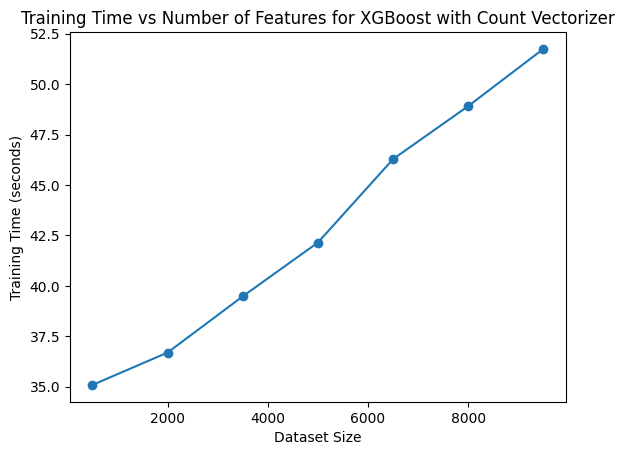

In [31]:
# Plot or analyze the training times against the dataset size
plt.plot(range(500,10001,1500), training_times_count, marker='o')
plt.title('Training Time vs Number of Features for XGBoost with Count Vectorizer')
plt.xlabel('Dataset Size')
plt.ylabel('Training Time (seconds)')
plt.show()

#### Tf-IDf Vectorizer

#### Defining the parameter grid for Tf-Idf

In [11]:
# Define the parameter grid for RandomizedSearchCV
param_dist_tfidf = {
    'vectorizer__ngram_range': [(1, 1), (1, 2), (2, 2)],
    'classifier__n_estimators': range(10,201,10),
    'classifier__max_depth': np.arange(3,11,1),
    'classifier__learning_rate': np.arange(0.1,2.0,0.05),
}


#### Using Tf-Idf for the whole dataset

In [12]:
pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('classifier', XGBClassifier())
])
random_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_dist_tfidf,
    n_iter=15,
    scoring='f1',
    n_jobs=8,
    cv=3,
    verbose=1,
    random_state=42
)

# Record the training time
start_time = time.time()
# Fit the model
random_search.fit(X_train, y_train)

end_time = time.time()

# Calculate and store the training time
training_time_tfidf_whole = end_time - start_time

# # Print the best parameters and best score
print("Best Parameters: ", random_search.best_params_)
print("Best F1 Score: {:.4f}".format(random_search.best_score_))

# # Evaluate the model on the test set
test_f1_score = random_search.score(X_test, y_test)
print("Test F1: {:.4f}".format(test_f1_score))
print("Training time for whole data set: {:.4f}".format(training_time_tfidf_whole))

Fitting 3 folds for each of 15 candidates, totalling 45 fits
Best Parameters:  {'vectorizer__ngram_range': (1, 1), 'classifier__n_estimators': 120, 'classifier__max_depth': 3, 'classifier__learning_rate': 0.3500000000000001}
Best F1 Score: 0.9413
Test F1: 0.9254
Training time for whole data set: 318.6406


#### Parameter Tuning

In [13]:
training_times_tfidf = []

best_tfidf_f1 = 0.0
best_tfidf_max_features = None
best_tfidf_parameters = {}

# Initialize the RandomizedSearchCV
for max_features in range(500,10001,1500):
    # Create a pipeline with tfidfVectorizer and XGBoost
    pipeline = Pipeline([
        ('vectorizer', TfidfVectorizer(max_features=max_features)),
        ('classifier', XGBClassifier())
    ])
    random_search = RandomizedSearchCV(
        pipeline,
        param_distributions=param_dist_tfidf,
        n_iter=15,
        scoring='f1',
        n_jobs=8,
        cv=3,
        verbose=1,
        random_state=42
    )

    # Record the training time
    start_time = time.time()
    # Fit the model
    random_search.fit(X_train, y_train)

    end_time = time.time()

    # Calculate and store the training time
    training_time = end_time - start_time
    training_times_tfidf.append(training_time)

    # # Print the best parameters and best score
    # print("Best Parameters: ", random_search.best_params_)
    # print("Best F1 Score: {:.4f}".format(random_search.best_score_))

    # # Evaluate the model on the test set
    test_f1_score = random_search.score(X_test, y_test)
    # print("Test F1: {:.4f}".format(test_f1_score))

     # Update the best test accuracy if the current iteration performs better
    if test_f1_score > best_tfidf_f1:
        best_tfidf_f1 = test_f1_score
        best_tfidf_max_features = max_features
        best_tfidf_parameters = random_search.best_params_

# Print the overall best test accuracy and corresponding parameters
print("\nOverall Best Test F1 Score:", best_tfidf_f1)
print("Corresponding Best max_features:", best_tfidf_max_features)
print("Corresponding Best Parameters:", best_tfidf_parameters)

Fitting 3 folds for each of 15 candidates, totalling 45 fits
Fitting 3 folds for each of 15 candidates, totalling 45 fits
Fitting 3 folds for each of 15 candidates, totalling 45 fits
Fitting 3 folds for each of 15 candidates, totalling 45 fits
Fitting 3 folds for each of 15 candidates, totalling 45 fits
Fitting 3 folds for each of 15 candidates, totalling 45 fits
Fitting 3 folds for each of 15 candidates, totalling 45 fits

Overall Best Test F1 Score: 0.9392446633825944
Corresponding Best max_features: 500
Corresponding Best Parameters: {'vectorizer__ngram_range': (1, 1), 'classifier__n_estimators': 120, 'classifier__max_depth': 3, 'classifier__learning_rate': 0.3500000000000001}


In [14]:
training_times_tfidf

[59.07223963737488,
 75.07714819908142,
 82.66993379592896,
 89.66126418113708,
 96.04552674293518,
 99.15132427215576,
 103.63643836975098]

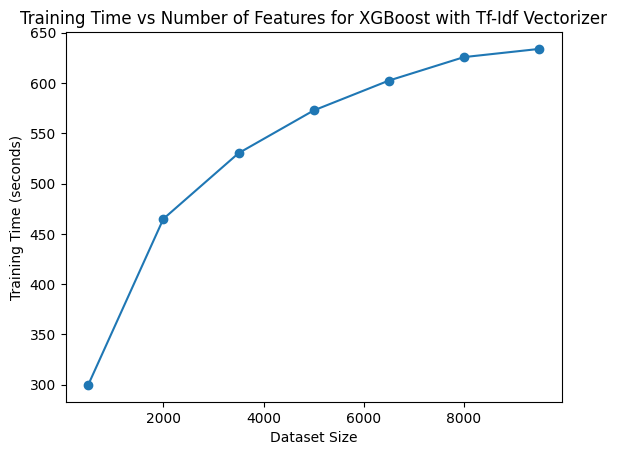

In [30]:
# Plot or analyze the training times against the dataset size
plt.plot(range(500,10001,1500), training_times_tfidf, marker='o')
plt.title('Training Time vs Number of Features for XGBoost with Tf-Idf Vectorizer')
plt.xlabel('Dataset Size')
plt.ylabel('Training Time (seconds)')
plt.show()

## Second Dataset

In [16]:
english_news_df = pd.read_csv('./Philippine_Fake_News_Corpus.csv')

In [17]:
english_news_df.head()

,Headline,Content,Authors,Date,URL,Brand,Label
0,PH ranks 2nd in Asia-Pacific in deaths due to ...,Pollution caused by traditional cooking fuel i...,['Philippine Daily Inquirer'],NaN,https://newsinfo.inquirer.net/987262/ph-ranks-...,Inquirer,Credible
1,"Aguirre, PCSO chief deny plotting to kill ‘Ato...",Justice Secretary Vitaliano Aguirre 2nd and Ph...,['Jomar Canlas'],2017-04-28 20:12:54+00:00,https://www.manilatimes.net/aguirre-pcso-chief...,Manila Times,Credible
2,Duterte says charges vs ex-President will fail,President Rodrigo Duterte on Monday night desc...,['Christine O. Avendaño'],NaN,https://newsinfo.inquirer.net/914727/duterte-s...,Inquirer,Credible
3,Group warns BFAR on law enforcement fund,THE militant fisher folk group Pambansang Laka...,['Neil Alcober'],2017-08-12 19:54:48+00:00,https://www.manilatimes.net/group-warns-bfar-l...,Manila Times,Credible
4,Solon asks Duterte for jet ski to Panatag,Magdalo Rep. Gary Alejano is willing to lead t...,['Dj Yap'],NaN,https://newsinfo.inquirer.net/882744/solon-ask...,Inquirer,Credible


In [18]:
label_encoder = LabelEncoder()

# Encode the 'Label' column
english_news_df['Label'] = label_encoder.fit_transform(english_news_df['Label'])

# The mapping between original labels and encoded values
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
# Print the mapping
print("Label Mapping:", label_mapping)

Label Mapping: {'Credible': 0, 'Not Credible': 1}


In [19]:
X = english_news_df['Content']
y = english_news_df['Label']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7, random_state=42)

In [20]:
vectorizer = CountVectorizer()

# Fit and transform the 'text' column to get the document-term matrix
temp = vectorizer.fit_transform(english_news_df['Content'])

# Get the vocabulary from the vectorizer
english_vocabulary = vectorizer.get_feature_names_out()

# Get the size of the vocabulary
vocabulary_size = len(english_vocabulary)
print(vocabulary_size)

119472


#### Count Vectorizer

#### Setting the range of parameters for tuning

In [21]:
param_dist_count = {
    'vectorizer__ngram_range': [(1, 1), (1, 2), (2, 2)],
    'classifier__n_estimators': range(50,201,10),
    'classifier__max_depth': np.arange(3,7,1),
    'classifier__learning_rate': np.arange(0.1,2.0,0.1),
}

##### Using the Whole Vocabulary

In [29]:
pipeline = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('classifier', XGBClassifier())
])
random_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_dist_count,
    n_iter=15,
    scoring='f1',
    n_jobs=8,
    cv=3,
    verbose=1,
    random_state=42
)

# Record the training time
start_time = time.time()
random_search.fit(X_train, y_train)
end_time = time.time()
training_time_count_whole2 = end_time - start_time

# Print the best parameters and best score
print("Best Parameters: ", random_search.best_params_)
print("Best F1 Score: {:.4f}".format(random_search.best_score_))

# # Evaluate the model on the test set
test_f1_score = random_search.score(X_test, y_test)
print("Test F1: {:.4f}".format(test_f1_score))
print("Training time for whole data set: {:.4f}".format(training_time_count_whole2))


Fitting 3 folds for each of 15 candidates, totalling 45 fits


KeyboardInterrupt: 

In [22]:
training_times_count_dataset2 = []

best_count_f1_dataset2 = 0.0
best_count_max_features_dataset2 = None
best_count_parameters_dataset2 = {}

# Initialize the RandomizedSearchCV
for max_features in range(500,10001,1500):
    # Create a pipeline with CountVectorizer and XGBoost
    pipeline = Pipeline([
        ('vectorizer', CountVectorizer(max_features=max_features)),
        ('classifier', XGBClassifier())
    ])
    random_search = RandomizedSearchCV(
        pipeline,
        param_distributions=param_dist_count,
        n_iter=15,
        scoring='f1',
        n_jobs=8,
        cv=3,
        verbose=1,
        random_state=42
    )

    # Record the training time
    start_time = time.time()
    # Fit the model
    random_search.fit(X_train, y_train)

    end_time = time.time()

    # Calculate and store the training time
    training_time = end_time - start_time
    training_times_count_dataset2.append(training_time)

    # # Print the best parameters and best score
    # print("Best Parameters: ", random_search.best_params_)
    # print("Best F1 Score: {:.4f}".format(random_search.best_score_))

    # # Evaluate the model on the test set
    test_f1_score = random_search.score(X_test, y_test)
    # print("Test F1: {:.4f}".format(test_score_f1))

     # Update the best test accuracy if the current iteration performs better
    if test_f1_score > best_count_f1_dataset2:
        best_count_f1_dataset2 = test_f1_score
        best_count_max_features_dataset2 = max_features
        best_count_parameters_dataset2 = random_search.best_params_

# Print the overall best test accuracy and corresponding parameters
print("\nOverall Best Test F1 Score:", best_count_f1_dataset2)
print("Corresponding Best max_features:", best_count_max_features_dataset2)
print("Corresponding Best Parameters:", best_count_parameters_dataset2)

Fitting 3 folds for each of 15 candidates, totalling 45 fits
Fitting 3 folds for each of 15 candidates, totalling 45 fits
Fitting 3 folds for each of 15 candidates, totalling 45 fits
Fitting 3 folds for each of 15 candidates, totalling 45 fits
Fitting 3 folds for each of 15 candidates, totalling 45 fits
Fitting 3 folds for each of 15 candidates, totalling 45 fits
Fitting 3 folds for each of 15 candidates, totalling 45 fits

Overall Best Test F1 Score: 0.923964441081899
Corresponding Best max_features: 8000
Corresponding Best Parameters: {'vectorizer__ngram_range': (1, 2), 'classifier__n_estimators': 160, 'classifier__max_depth': 4, 'classifier__learning_rate': 0.30000000000000004}


#### Training Time vs Number of Features in Vocabulary

In [23]:
training_times_count_dataset2

[161.271160364151,
 170.36433267593384,
 183.0112977027893,
 191.8761329650879,
 203.63714838027954,
 210.11015272140503,
 215.5150182247162]

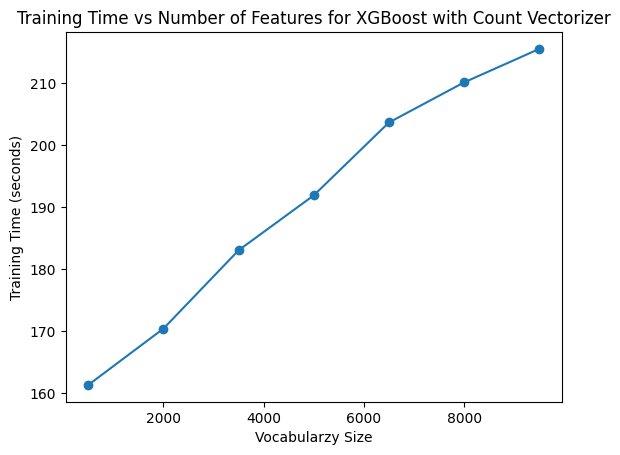

In [24]:
# Plot or analyze the training times against the dataset size
plt.plot(range(500,10001,1500), training_times_count_dataset2, marker='o')
plt.title('Training Time vs Number of Features for XGBoost with Count Vectorizer')
plt.xlabel('Vocabularzy Size')
plt.ylabel('Training Time (seconds)')
plt.show()

#### Tf-IDf Vectorizer

#### Defining the parameter grid for Tf-Idf

In [25]:
# Define the parameter grid for RandomizedSearchCV
param_dist_tfidf = {
    'vectorizer__ngram_range': [(1, 1), (1, 2), (2, 2)],
    'classifier__n_estimators': range(50,201,10),
    'classifier__max_depth': np.arange(3,7,1),
    'classifier__learning_rate': np.arange(0.1,2.0,0.1),
}


#### Using Tf-Idf for the whole dataset

In [ ]:
pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('classifier', XGBClassifier())
])
random_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_dist_tfidf,
    n_iter=15,
    scoring='f1',
    n_jobs=6,
    cv=3,
    verbose=1,
    random_state=42
)

# Record the training time
start_time = time.time()
# Fit the model
random_search.fit(X_train, y_train)

end_time = time.time()

# Calculate and store the training time
training_time_tfidf_whole = end_time - start_time

# # Print the best parameters and best score
print("Best Parameters: ", random_search.best_params_)
print("Best F1 Score: {:.4f}".format(random_search.best_score_))

# # Evaluate the model on the test set
test_f1_score = random_search.score(X_test, y_test)
print("Test F1: {:.4f}".format(test_f1_score))
print("Training time for whole data set: {:.4f}".format(training_time_tfidf_whole))

#### Parameter Tuning

In [26]:
training_times_tfidf = []

best_tfidf_f1 = 0.0
best_tfidf_max_features = None
best_tfidf_parameters = {}

# Initialize the RandomizedSearchCV
for max_features in range(500,10001,1500):
    # Create a pipeline with tfidfVectorizer and XGBoost
    pipeline = Pipeline([
        ('vectorizer', TfidfVectorizer(max_features=max_features)),
        ('classifier', XGBClassifier())
    ])
    random_search = RandomizedSearchCV(
        pipeline,
        param_distributions=param_dist_tfidf,
        n_iter=15,
        scoring='f1',
        n_jobs=8,
        cv=3,
        verbose=1,
        random_state=42
    )

    # Record the training time
    start_time = time.time()
    # Fit the model
    random_search.fit(X_train, y_train)

    end_time = time.time()

    # Calculate and store the training time
    training_time = end_time - start_time
    training_times_tfidf.append(training_time)

    # # Print the best parameters and best score
    # print("Best Parameters: ", random_search.best_params_)
    # print("Best F1 Score: {:.4f}".format(random_search.best_score_))

    # # Evaluate the model on the test set
    test_f1_score = random_search.score(X_test, y_test)
    # print("Test F1: {:.4f}".format(test_f1_score))

     # Update the best test accuracy if the current iteration performs better
    if test_f1_score > best_tfidf_f1:
        best_tfidf_f1 = test_f1_score
        best_tfidf_max_features = max_features
        best_tfidf_parameters = random_search.best_params_

# Print the overall best test accuracy and corresponding parameters
print("\nOverall Best Test F1 Score:", best_tfidf_f1)
print("Corresponding Best max_features:", best_tfidf_max_features)
print("Corresponding Best Parameters:", best_tfidf_parameters)

Fitting 3 folds for each of 15 candidates, totalling 45 fits
Fitting 3 folds for each of 15 candidates, totalling 45 fits
Fitting 3 folds for each of 15 candidates, totalling 45 fits
Fitting 3 folds for each of 15 candidates, totalling 45 fits
Fitting 3 folds for each of 15 candidates, totalling 45 fits
Fitting 3 folds for each of 15 candidates, totalling 45 fits
Fitting 3 folds for each of 15 candidates, totalling 45 fits

Overall Best Test F1 Score: 0.923251847640705
Corresponding Best max_features: 8000
Corresponding Best Parameters: {'vectorizer__ngram_range': (1, 2), 'classifier__n_estimators': 160, 'classifier__max_depth': 4, 'classifier__learning_rate': 0.30000000000000004}


In [27]:
training_times_tfidf

[299.7906835079193,
 464.9085040092468,
 530.2437424659729,
 572.7509367465973,
 602.4410536289215,
 625.8120522499084,
 633.9540543556213]

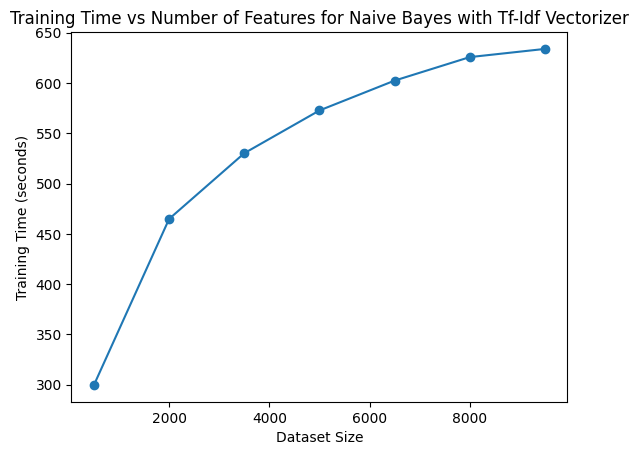

In [28]:
# Plot or analyze the training times against the dataset size
plt.plot(range(500,10001,1500), training_times_tfidf, marker='o')
plt.title('Training Time vs Number of Features for Naive Bayes with Tf-Idf Vectorizer')
plt.xlabel('Dataset Size')
plt.ylabel('Training Time (seconds)')
plt.show()